In [91]:
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [4]:
with open('data/dx.json') as f:
    pars_dx = json.load(f)
    
with open('data/itr.json') as f:
    dat_itr = json.load(f)    


In [5]:
dat_itr

{'Presumptive': {'SSM': 13914911, 'CBNAAT': 1370649, 'Truenat': 2749903},
 'Notification': {'Sector_Public': 1688427,
  'Sector_Private': 733694,
  'Type_New': 2131704,
  'Type_Treated': 226960,
  'Type_PMDT': 63457,
  'Test_SSM': 513050,
  'Test_Xpert': 548981,
  'Test_CXR': 835930,
  'Test_Other': 1037210},
 'Test_Truenat': {'Tested': 3483130,
  'Detected': 529196,
  'TestRif': 490267,
  'DetectedRif': 21659,
  'Tested_Private': 215594,
  'Detected_Private': 53067,
  'DetectedRif_Private': 3735},
 'Test_CBNAAT': {'Tested': 2365739,
  'Detected': 525088,
  'DetectedRif': 42026,
  'Tested_Private': 262160,
  'Detected_Private': 68556,
  'DetectedRif_Private': 6531},
 'Test_LPA': {'Tested': 309719, 'DetectedRif': 27180},
 'Year': 2022,
 'Location': 'India'}

In [6]:
pars_dx

{'sens_ssm': 0.64,
 'spec_ssm': 0.98,
 'sens_xpert': 0.85,
 'sens_xpert_ss-': 0.64,
 'spec_xpert': 0.98,
 'p_ava_xpert_pub': 0.2,
 'p_ava_ssm_pub': 0.8,
 'p_ava_xpert_eng': 0.3,
 'p_loss_sputum': 0.15,
 'p_loss_swab': 0.02,
 'sens_cdx': 0.7,
 'spec_cdx': 0.95,
 'p_csi_pub': 0.483,
 'p_csi_ppm': 0.6,
 'dur_pri': 0.7,
 'dur_pub': 0.5,
 'p_txi_pub': 0.9,
 'p_txi_eng': 0.8,
 'p_txi_pri': 0.8,
 'p_refer_i2u': 0.3}

In [46]:
def combine_algs(pars, p_loss_sputum):
    sens_ssm, spec_ssm = pars['sens_ssm'], pars['spec_ssm']
    sens_xpert, spec_xpert = pars['sens_xpert'], pars['spec_xpert']
    sens_xsn, spec_xsn = pars['sens_xpert_ss-'], pars['spec_xpert']
    
    sens_sx, spec_sx = sens_ssm + (1 - sens_ssm) * sens_xsn, (1 - spec_ssm) + spec_ssm *  (1 - spec_xsn)
    
    tp, fn = (1 - p_loss_sputum) * sens_ssm, (1 - p_loss_sputum) * (1 - sens_ssm) + p_loss_sputum
    fp, tn = (1 - p_loss_sputum) * (1 - spec_ssm), (1 - p_loss_sputum) * spec_ssm + p_loss_sputum
    
    alg_ssm = { 'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn, 'TP_S': tp, 'FP_S': fp, 'TP_X': 0, 'FP_X': 0 }
    
    tp, fn = (1 - p_loss_sputum) * sens_xpert, (1 - p_loss_sputum) * (1 - sens_xpert) + p_loss_sputum
    fp, tn = (1 - p_loss_sputum) * (1 - spec_xpert), (1 - p_loss_sputum) * spec_xpert + p_loss_sputum
    
    alg_xpert = { 'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn, 'TP_S': 0, 'FP_S': 0, 'TP_X': tp, 'FP_X': fp }
    
    tp, fn = (1 - p_loss_sputum) * sens_sx, (1 - p_loss_sputum) * (1 - sens_sx) + p_loss_sputum
    tp_s = (1 - p_loss_sputum) * sens_ssm
    fp, tn = (1 - p_loss_sputum) * (1 - spec_sx), (1 - p_loss_sputum) * spec_sx + p_loss_sputum
    fp_s = (1 - p_loss_sputum) * (1 - spec_ssm)
    
    alg_sx = { 'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn, 'TP_S': tp_s, 'FP_S': fp_s, 'TP_X': tp - tp_s, 'FP_X': fp - fp_s }
    
    return { 'SSM': alg_ssm, 'Xpert': alg_xpert, 'SX': alg_sx }

In [47]:
def find_p(sens, spec, n, x):
    p = x / n - (1 - spec)
    p /= (sens - (1 - spec))
    return p

In [157]:
def calc_cdx(dat_itr, pars_dx, p_loss_sputum):
    res = dict()
    res['p_loss_sputum'] = p_loss_sputum
    n_ssm = dat_itr['Presumptive']['SSM']
    x_ssm = dat_itr['Notification']['Test_SSM']

    n_xpert = dat_itr['Presumptive']['CBNAAT'] + dat_itr['Presumptive']['Truenat']
    x_xpert = dat_itr['Notification']['Test_Xpert']

    res['x_cdx'] = x_cdx = dat_itr['Notification']['Test_CXR'] + dat_itr['Notification']['Test_Other']
    res['x_bac'] = x_bac = dat_itr['Notification']['Test_SSM'] + dat_itr['Notification']['Test_Xpert']
    
    d1 = dat_itr['Test_Truenat']
    d2 = dat_itr['Test_CBNAAT']

    res['p_pri_xpert'] = p_pri_xpert = (d1['Tested_Private'] + d2['Tested_Private'])/ (d1['Tested'] + d2['Tested'])
    
    res['algs'] = algs = combine_algs(pars_dx, p_loss_sputum)
    res['p_tb'] = p_tb = find_p(algs['SSM']['TP'], algs['SSM']['TN'], n_ssm, x_ssm)

    tp_ssm, fp_ssm = n_ssm * p_tb * algs['SSM']['TP'], n_ssm * (1 - p_tb) * algs['SSM']['FP']
    tp_x, fp_x = n_xpert * p_tb * algs['Xpert']['TP'], n_xpert * (1 - p_tb) * algs['Xpert']['FP']
    
    x_sx = x_xpert - tp_x - fp_x

    p_sx = x_sx / (n_ssm * p_tb * algs['SX']['TP_X'] + n_ssm * (1 - p_tb) * algs['SX']['FP_X'])
    
    res['n_access_x'] = n_access_x = n_xpert
    res['n_access_s'] = n_access_s = n_ssm * (1 - p_sx)
    res['n_access_sx'] = n_access_sx = n_ssm * p_sx
    
    n_tb, n_nontb = n_access_s * p_tb, n_access_s * (1 - p_tb)
    tp_s, fp_s, fn_s, tn_s = n_tb * algs['SSM']['TP'], n_nontb * algs['SSM']['FP'], n_tb * algs['SSM']['FN'], n_nontb * algs['SSM']['TN']
    
    n_tb, n_nontb = n_access_x * p_tb, n_access_x * (1 - p_tb)
    tp_x, fp_x, fn_x, tn_x = n_tb * algs['Xpert']['TP'], n_nontb * algs['Xpert']['FP'], n_tb * algs['Xpert']['FN'], n_nontb * algs['Xpert']['TN']
    
    n_tb, n_nontb = n_access_sx * p_tb, n_access_sx * (1 - p_tb)
    tp_sx, fp_sx, fn_sx, tn_sx = n_tb * algs['SX']['TP'], n_nontb * algs['SX']['FP'], n_tb * algs['SX']['FN'], n_nontb * algs['SX']['TN']
    
    test_xpert = n_access_sx * p_tb * (1 - algs['SX']['TP_S']) + n_access_sx * (1 - p_tb) * (1 - algs['SX']['FP_S']) + n_access_x
    n_access_x_pri = test_xpert * p_pri_xpert
    n_access_x_pub = n_access_x - n_access_x_pri
    p_pri = n_access_x_pri / n_access_x
    res['n_access_x_pub'], res['n_access_x_pri'] = n_access_x_pub, n_access_x_pri
    
    res['tp_x_pri'], res['fp_x_pri'] = tp_x * p_pri, fp_x * p_pri
    res['fn_x_pri'], res['tn_x_pri'] = fn_x * p_pri, tn_x * p_pri
    x_cdx_pri = dat_itr['Notification']['Sector_Private'] - res['tp_x_pri'] - res['fp_x_pri']
    x_cdx_pub = x_cdx - x_cdx_pri
    
    # CDx with pathways have CDx always after Bac
    n_tb_cdx = p_tb * (n_access_x * algs['Xpert']['FN'] + n_access_s * algs['SSM']['FN'] + n_access_sx * algs['SX']['FN'])
    n_nontb_cdx = (1 - p_tb) * (n_access_x * algs['Xpert']['TN'] + n_access_s * algs['SSM']['TN'] + n_access_sx * algs['SX']['TN'])
    
    ds = list()
    for sens in np.linspace(0, 1, 101):
        spec = 1 - (x_cdx - n_tb_cdx * sens) / n_nontb_cdx
        ds.append({'Sens': sens, 'Spec': spec, 'TP_CDx': n_tb_cdx * sens, 'FP_CDx': n_nontb_cdx * (1 - spec)})
    ds = [d for d in ds if 0 <= d['Spec'] <= 1]
    res['AccCDx_AfterBac'] = ds = pd.DataFrame(ds)
    
    # CDx with pathways start without Bac
    p_ava_x = n_access_sx / (n_access_s + n_access_sx)
    n_access_cdx_pub = n_access_x_pub * (1 - p_ava_x) / p_ava_x

    n_tb_cdx = p_tb * (n_access_x_pub * algs['Xpert']['FN'] + n_access_s * algs['SSM']['FN'] + n_access_sx * algs['SX']['FN'])
    n_nontb_cdx = (1 - p_tb) * (n_access_x_pub * algs['Xpert']['TN'] + n_access_s * algs['SSM']['TN'] + n_access_sx * algs['SX']['TN'])
    n_tb_cdx += n_access_cdx_pub * p_tb
    n_nontb_cdx += n_access_cdx_pub * (1 - p_tb)

    ds2 = list()
    for sens in np.linspace(0, 1, 101):
        spec = 1 - (x_cdx_pub - n_tb_cdx * sens) / n_nontb_cdx
        
        p_dx_pub = n_tb_cdx * sens + tp_x * p_pri + tp_s + tp_sx
        p_dx_pub /= (n_access_cdx_pub + n_access_x_pub + n_access_sx + n_access_s) * p_tb
        
        n_cdxonly = x_cdx_pri - (res['fn_x_pri'] * sens + res['tn_x_pri'] * (1 - spec))
        n_access_cdx_pri = n_cdxonly / (p_tb * sens + (1 - p_tb) * (1 - spec))
        
        p_dx_pri = (n_access_cdx_pri * p_tb * sens + res['tp_x_pri']) 
        p_dx_pri /= (n_access_cdx_pri + n_access_x_pri) * p_tb

        ds2.append({'Sens': sens, 'Spec': spec, 'TP_CDx': n_tb_cdx * sens, 'FP_CDx': n_nontb_cdx * (1 - spec), 
                    'N_CDx_Pri': n_access_cdx_pri, 'PDx_Pub': p_dx_pub, 'PDx_Pri': p_dx_pri})

    ds2 = [d for d in ds2 if 0 <= d['Spec'] <= 1]
    res['AccCDx_Ind'] = ds2 = pd.DataFrame(ds2)

    return res

In [158]:
sc1 = calc_cdx(dat_itr, pars_dx, p_loss_sputum=0.15)
sc2 = calc_cdx(dat_itr, pars_dx, p_loss_sputum=0.25)
sc3 = calc_cdx(dat_itr, pars_dx, p_loss_sputum=0.5)

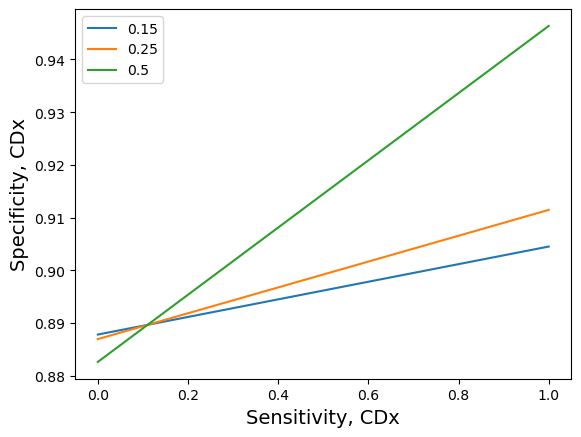

In [159]:
for sc in [sc1, sc2, sc3]:
    ds = sc['AccCDx_AfterBac']
    plt.plot(ds.Sens, ds.Spec, label = sc['p_loss_sputum'])
plt.xlabel('Sensitivity, CDx', fontsize=14)
plt.ylabel('Specificity, CDx', fontsize=14)
plt.legend()

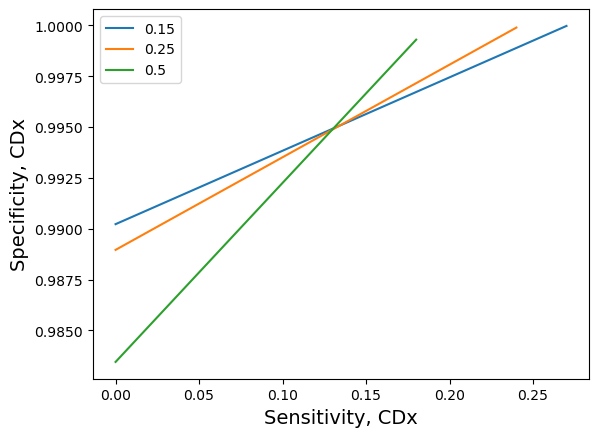

In [160]:
for sc in [sc1, sc2, sc3]:
    ds = sc['AccCDx_Ind']
    plt.plot(ds.Sens, ds.Spec, label = sc['p_loss_sputum'])
plt.xlabel('Sensitivity, CDx', fontsize=14)
plt.ylabel('Specificity, CDx', fontsize=14)
plt.legend()

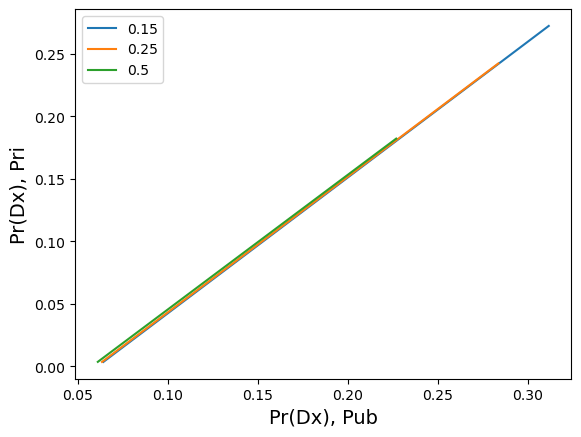

In [161]:
for sc in [sc1, sc2, sc3]:
    ds = sc['AccCDx_Ind']
    plt.plot(ds.PDx_Pub, ds.PDx_Pri, label = sc['p_loss_sputum'])
plt.xlabel('Pr(Dx), Pub', fontsize=14)
plt.ylabel('Pr(Dx), Pri', fontsize=14)
plt.legend()

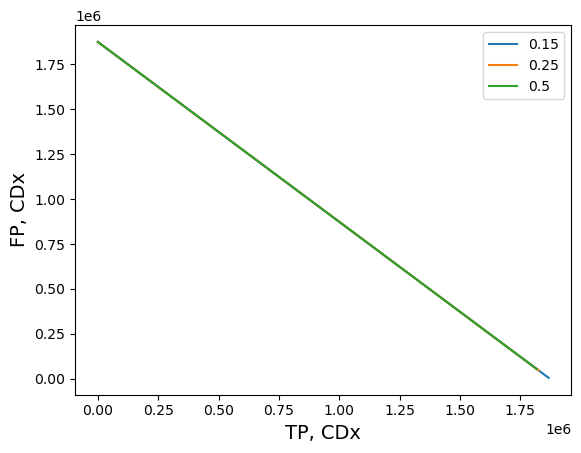

In [138]:
for sc in [sc1, sc2, sc3]:
    ds = sc['AccCDx_Ind']
    plt.plot(ds.TP_CDx, ds.FP_CDx, label = sc['p_loss_sputum'])
plt.xlabel('TP, CDx', fontsize=14)
plt.ylabel('FP, CDx', fontsize=14)
plt.legend()

In [166]:
cnr = dat_itr['Notification']
cnr

{'Sector_Public': 1688427,
 'Sector_Private': 733694,
 'Type_New': 2131704,
 'Type_Treated': 226960,
 'Type_PMDT': 63457,
 'Test_SSM': 513050,
 'Test_Xpert': 548981,
 'Test_CXR': 835930,
 'Test_Other': 1037210}

In [170]:
(cnr['Sector_Public'] * 0.59 + cnr['Sector_Private'] * 0.28) / (cnr['Test_Xpert'] + cnr['Test_SSM'])

1.131422952813995

In [171]:
cnr

{'Sector_Public': 1688427,
 'Sector_Private': 733694,
 'Type_New': 2131704,
 'Type_Treated': 226960,
 'Type_PMDT': 63457,
 'Test_SSM': 513050,
 'Test_Xpert': 548981,
 'Test_CXR': 835930,
 'Test_Other': 1037210}

In [184]:
def calc_pri(dat_itr, pars_dx, p_loss_sputum, p_bac_pri):
    res = dict()
    res['p_loss_sputum'] = p_loss_sputum
    n_ssm = dat_itr['Presumptive']['SSM']
    x_ssm = dat_itr['Notification']['Test_SSM']

    n_xpert = dat_itr['Presumptive']['CBNAAT'] + dat_itr['Presumptive']['Truenat']
    x_xpert = dat_itr['Notification']['Test_Xpert']

    res['x_cdx'] = x_cdx = dat_itr['Notification']['Test_CXR'] + dat_itr['Notification']['Test_Other']
    res['x_bac'] = x_bac = dat_itr['Notification']['Test_SSM'] + dat_itr['Notification']['Test_Xpert']
    
    res['algs'] = algs = combine_algs(pars_dx, p_loss_sputum)
    res['p_tb'] = p_tb = find_p(algs['SSM']['TP'], algs['SSM']['TN'], n_ssm, x_ssm)

    tp_ssm, fp_ssm = n_ssm * p_tb * algs['SSM']['TP'], n_ssm * (1 - p_tb) * algs['SSM']['FP']
    tp_x, fp_x = n_xpert * p_tb * algs['Xpert']['TP'], n_xpert * (1 - p_tb) * algs['Xpert']['FP']
    
    x_sx = x_xpert - tp_x - fp_x

    p_sx = x_sx / (n_ssm * p_tb * algs['SX']['TP_X'] + n_ssm * (1 - p_tb) * algs['SX']['FP_X'])
    
    res['n_access_x'] = n_access_x = n_xpert
    res['n_access_s'] = n_access_s = n_ssm * (1 - p_sx)
    res['n_access_sx'] = n_access_sx = n_ssm * p_sx
    
    n_tb, n_nontb = n_access_s * p_tb, n_access_s * (1 - p_tb)
    tp_s, fp_s, fn_s, tn_s = n_tb * algs['SSM']['TP'], n_nontb * algs['SSM']['FP'], n_tb * algs['SSM']['FN'], n_nontb * algs['SSM']['TN']
    
    n_tb, n_nontb = n_access_x * p_tb, n_access_x * (1 - p_tb)
    tp_x, fp_x, fn_x, tn_x = n_tb * algs['Xpert']['TP'], n_nontb * algs['Xpert']['FP'], n_tb * algs['Xpert']['FN'], n_nontb * algs['Xpert']['TN']
    
    n_tb, n_nontb = n_access_sx * p_tb, n_access_sx * (1 - p_tb)
    tp_sx, fp_sx, fn_sx, tn_sx = n_tb * algs['SX']['TP'], n_nontb * algs['SX']['FP'], n_tb * algs['SX']['FN'], n_nontb * algs['SX']['TN']
    
    test_xpert = n_access_sx * p_tb * (1 - algs['SX']['TP_S']) + n_access_sx * (1 - p_tb) * (1 - algs['SX']['FP_S']) + n_access_x
    
    x_x_pri = dat_itr['Notification']['Sector_Private'] * p_bac_pri
    
    res['p_pri_xpert'] = p_pri = x_x_pri / (tp_x + fp_x) 
    n_access_x_pri = n_access_x * p_pri
    n_access_x_pub = n_access_x - n_access_x_pri
    
    res['n_access_x_pub'], res['n_access_x_pri'] = n_access_x_pub, n_access_x_pri
    
    res['tp_x_pri'], res['fp_x_pri'] = tp_x * p_pri, fp_x * p_pri
    res['fn_x_pri'], res['tn_x_pri'] = fn_x * p_pri, tn_x * p_pri
    
    x_cdx_pri = dat_itr['Notification']['Sector_Private'] - res['tp_x_pri'] - res['fp_x_pri']
    x_cdx_pub = x_cdx - x_cdx_pri
    
    # CDx with pathways have CDx always after Bac
    n_tb_cdx = p_tb * (n_access_x_pub * algs['Xpert']['FN'] + n_access_s * algs['SSM']['FN'] + n_access_sx * algs['SX']['FN'])
    n_nontb_cdx = (1 - p_tb) * (n_access_x_pub * algs['Xpert']['TN'] + n_access_s * algs['SSM']['TN'] + n_access_sx * algs['SX']['TN'])
    
    ds = list()
    for sens in np.linspace(0, 1, 101):
        spec = 1 - (x_cdx_pub - n_tb_cdx * sens) / n_nontb_cdx
        ds.append({'Sens': sens, 'Spec': spec, 'TP_CDx': n_tb_cdx * sens, 'FP_CDx': n_nontb_cdx * (1 - spec)})
    ds = [d for d in ds if 0 <= d['Spec'] <= 1]
    res['AccCDx'] = ds = pd.DataFrame(ds)
    
    return res

In [187]:
sp1 = calc_pri(dat_itr, pars_dx, p_loss_sputum=0.15, p_bac_pri=0.2)
sp2 = calc_pri(dat_itr, pars_dx, p_loss_sputum=0.25, p_bac_pri=0.2)
sp3 = calc_pri(dat_itr, pars_dx, p_loss_sputum=0.5, p_bac_pri=0.2)

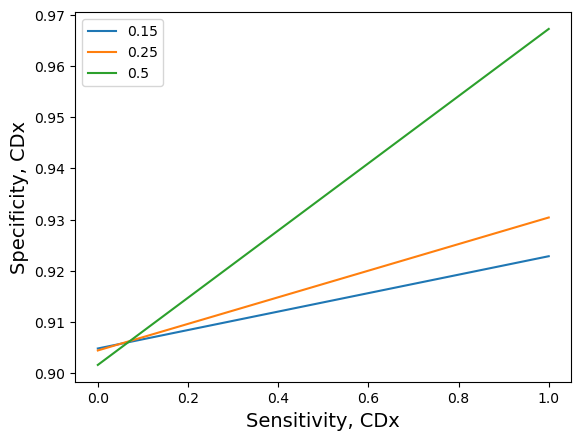

In [188]:
for sc in [sp1, sp2, sp3]:
    ds = sc['AccCDx']
    plt.plot(ds.Sens, ds.Spec, label = sc['p_loss_sputum'])
plt.xlabel('Sensitivity, CDx', fontsize=14)
plt.ylabel('Specificity, CDx', fontsize=14)
plt.legend()

In [209]:
calc_pri(dat_itr, pars_dx, p_loss_sputum=0.5, p_bac_pri=0.09)['p_pri_xpert']

0.34858631665106665

In [204]:
sp1

928623.0127795856

In [212]:
d1 = dat_itr['Test_Truenat']
d2 = dat_itr['Test_CBNAAT']

(d1['Detected_Private'] + d2['Detected_Private'])/ (d1['Detected'] + d2['Detected'])

0.11536075668415721

In [211]:
d1

{'Tested': 3483130,
 'Detected': 529196,
 'TestRif': 490267,
 'DetectedRif': 21659,
 'Tested_Private': 215594,
 'Detected_Private': 53067,
 'DetectedRif_Private': 3735}